### Introduction


**Problem Statement:** Model a classifier which takes in job description and gives the corresponding department name for the job.

The above problem statement was chosen as Job Description Classification is a problem most professionals today can appreciate and understand. The proposed solution for the problem covers important NLP and Data Science concepts such as tokenization, word embeddings, skip-gram, data visualization, class imbalance, data imputation and using CNNs for NLP, without being overwhelming.

**Problem Solving Approach:** 

1. EDA was done to gain insight on how imbalanced the classes are in the dataset. This was handled accordingly using oversampling by SMOTE for the minority classes. 

2. EDA also revealed there were some jobs for which the description was not provided. Two alternatives could have been taken. Empty job descriptions could be filled in by other job descriptions from the same department or they could be removed entirely. As some job descriptions were repeated, this could've been a viable alternative. However, for the sake of simplicity, such rows were removed. 

3. To gain insight on how lengthy the descriptions were for each Department, a box plot was plotted. Any trends in length or significant outliers can be handled through this information. 

4. As there were some Departments with only a few samples, they were removed as they wouldn't help much in training and would not allow SMOTE to function as a minimum number of samples is required. As acquiring more data did not seem like an option, such Departments were further dropped. Which left us with 15 Departments for training.

5. The model itself is a CNN with pretrained GloVe embeddings.

6. The model uses different convolution layers of filter sizes [3, 4 and 5]. This is done to emulate different skip-gram models where different filter sizes represent the number of words the filter is being applied to.

### Part I: Text Preprocessing

_Include all text preprocesing steps like processing of json,csv files & data cleaning in this part._

In [3]:
import pandas as pd
import os
import numpy as np
import json
import glob
import spacy
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [8]:
from imblearn.over_sampling import SMOTE
smote = SMOTE("minority",k_neighbors=3)

In [16]:
from sklearn.model_selection import train_test_split

### Part II: Exploratory Data Analysis


In [9]:
print(os.listdir("./data"))
encoder = LabelBinarizer()

['docs', 'document_departments.csv']


Number of unique Depts = 30
VAL Ticketing                          347
Sales                              270
Digital Marketing                  151
Customer service                    69
Marketing                           50
Finance                             42
Operations                          41
Administration                      38
Maintenance                         28
IT                                  20
Back office ticketing               18
Management Consulting               12
Presales                            10
Technology                          10
Analytics                            9
Engineering Design Construction      7
Recruitment                          6
Content                              6
Public Relations                     5
Airline Ground Operations            4
Marine Engineering                   3
Logistics                            3
Data entry                           2
Marine Deck                          2
QA                              

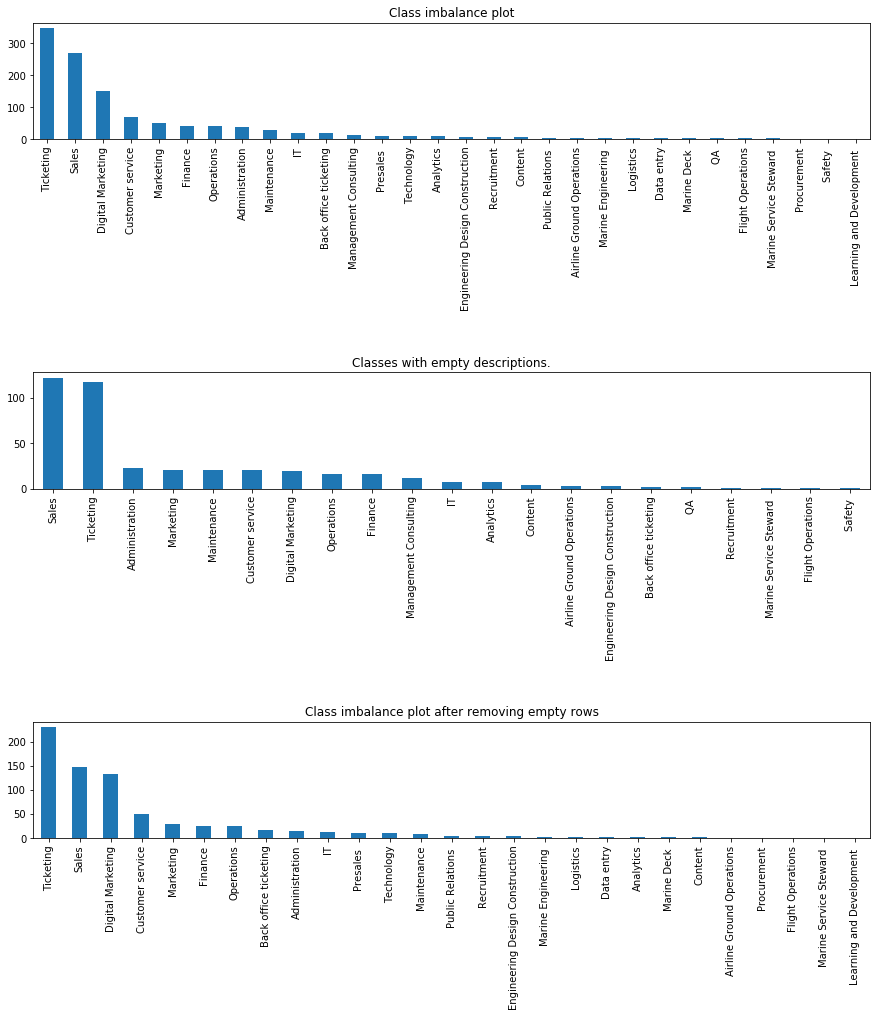

In [10]:
labels = pd.read_csv("./data/document_departments.csv")
labels = labels.rename(columns = {"Document ID" : "_id"})
# print(labels.shape)
# print(os.listdir("./data/docs"))
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,15))
fig.subplots_adjust(hspace=2)
path_to_json = "./data/docs"
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
stopwords = ["&amp","&nbsp"]

jsons_data = pd.DataFrame(columns=['_id','job_desc'])
# print(jsons_data.head())
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
        _id = int(json_text['_id'])
        CD = json_text['jd_information']["description"].split()
#         querywords = CD.split()
        resultwords  = [word for word in CD if word.lower() not in stopwords]
        CD = ' '.join(resultwords)
        jsons_data.loc[index]=[_id,CD]

# jsons_data.sort_values(by = ['_id'])
# print(jsons_data.head())
dat = (pd.merge(labels, jsons_data, left_on='_id', right_on='_id', how='left'))
dat = dat.set_index("_id")
# print(dat["Department"].value_counts())

# dat.Department = encoder.fit_transform(["dog", "cat", "bird"])

print("Number of unique Depts =", len(set(dat["Department"])))

dat["Department"].value_counts().plot(kind="bar",title="Class imbalance plot", ax=axes[0])

print("VAL",dat["Department"].value_counts())
# print(train_dat.head())
dat = (dat.sort_values(by=['_id']))

nlp = spacy.load('en')

dat['tokens'] = [nlp(text, # disable parts of the language processing pipeline we don't need here to speed up processing
                    disable=['ner', # named entity recognition
                                   'tagger', # part-of-speech tagger
                                   'textcat', # document label categorizer
                                  ]) for text in dat.job_desc]
# printdat.sample(5)
# print("Number of indices with empty descriptions =",list(dat[dat['job_desc'] == ''].index))
# print(dat.ix(1))
empty = dat[dat.index.isin(dat[dat['job_desc'] == ''].index)]
empty["Department"].value_counts().plot(kind="bar",title="Classes with empty descriptions.", ax=axes[1])

# removing empty rows with empty job_description.

edited_dat = dat.drop(list(dat[dat['job_desc'] == ''].index))
print("After dropping empty JD",edited_dat.shape)
print("Number of unique Depts in edited data =", len(set(edited_dat["Department"])))
print("Removed departments:",set(dat["Department"]).difference(edited_dat["Department"]))
edited_dat["Department"].value_counts().plot(kind="bar",title="Class imbalance plot after removing empty rows", ax=axes[2])

max len 722
Index(['Department', 'job_desc', 'tokens', 'num_tokens'], dtype='object')


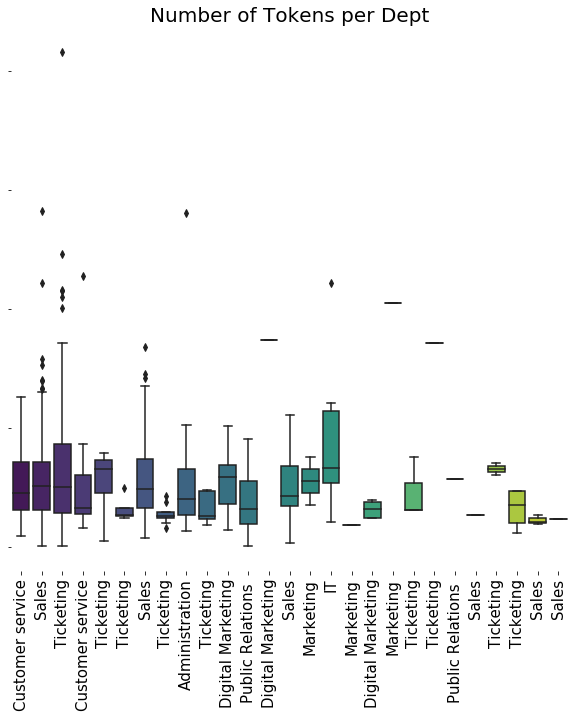

In [11]:
edited_dat['num_tokens'] = [len(token) for token in edited_dat.tokens]
print("max len", max([len(s.split()) for s in edited_dat.job_desc]))
# print("min len", min([len(s.split()) for s in edited_dat.job_desc]))
print(edited_dat.columns)
fig, ax = plt.subplots(figsize=(10,10))
g = sns.boxplot(x=edited_dat.Department, y=edited_dat.num_tokens, palette='viridis')
g.set_xticklabels(list(edited_dat.Department))
g.set_xticklabels(ax.get_xticklabels(), rotation=90)
g.set_yticklabels([])

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Number of Tokens per Dept', fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=15)
# fig.savefig('tokens.png')
plt.show()

In [12]:
## NN part starts here. First, shaping the data for feeding into the network.

# print(edited_dat.columns)
counts = edited_dat['Department'].value_counts()
edited_dat = edited_dat[edited_dat['Department'].isin(counts[counts > 4].index)]
X = edited_dat[["job_desc"]]
Y= pd.DataFrame(encoder.fit_transform(edited_dat["Department"].values), columns=encoder.classes_, index=edited_dat.index)
# # print(edited_dat.sample(5))
print(X.shape)
print(Y.shape)
# labels = np.asarray(Y,dtype="float32")
labels = Y.to_numpy()
# print("labs", labs)

# print(len(set(edited_dat.Department)))
# LabelBinarizer().fit_transform(edited_dat.Department).shape

(722, 1)
(722, 15)


In [13]:
MAX_SEQUENCE_LENGTH = 750 #722 was max length of job desc

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X["job_desc"])

vocab_size = len(tokenizer.word_index)+1
print("where vocab size is", vocab_size)
MAX_WORDS = 10000
EMBEDDING_DIM = 100
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 100
# dropout probability
drop = 0.5
batch_size = 30
epochs = 30

where vocab size is 6115


In [14]:
sequences =  tokenizer.texts_to_sequences(X["job_desc"])
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
# print(data)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (722, 750)
Shape of label tensor: (722, 15)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,test_size=0.20)
print(X_train.shape, y_train.shape)
X_sm, y_sm = smote.fit_sample(X_train, y_train)
print(X_sm.shape, y_sm.shape)

(577, 750) (577, 15)
(752, 750) (752, 15)


### Part III: Modelling & Evaluation

_Including all model prepration & evaluation steps in this part._

#### Word Embeddings

This part shows the concept of word embeddings (GloVe in this case), another core NLP concept which has applications in most NLP problems.

In [18]:
embeddings_index = {}
f = open('./glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [19]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [20]:

embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [21]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=15, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('job_desc_cnn.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
model.summary()

(?, 750, 100)
(?, 750, 100, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 750)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 750, 100)     611500      input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 750, 100, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 748, 1, 512)  154112      reshape_1[0][0]                  
______________________________________________________________________________

In [153]:
print("Training the Model:")
model.fit(X_sm, y_sm, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(X_train, y_train))

Training the Model:
Train on 752 samples, validate on 577 samples
Epoch 1/30
752/752 [==============================] - 3s 4ms/step - loss: 0.2971 - binary_accuracy: 0.9176 - categorical_accuracy: 0.1875 - val_loss: 0.1990 - val_binary_accuracy: 0.9421 - val_categorical_accuracy: 0.3380
Epoch 2/30
 60/752 [=>............................] - ETA: 1s - loss: 0.2307 - binary_accuracy: 0.9200 - categorical_accuracy: 0.3167

/home/armaan/Documents/gpu_env/lib/python3.5/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


752/752 [==============================] - 2s 3ms/step - loss: 0.2345 - binary_accuracy: 0.9235 - categorical_accuracy: 0.2952 - val_loss: 0.1763 - val_binary_accuracy: 0.9436 - val_categorical_accuracy: 0.3224
Epoch 3/30
752/752 [==============================] - 2s 3ms/step - loss: 0.2217 - binary_accuracy: 0.9294 - categorical_accuracy: 0.3391 - val_loss: 0.1601 - val_binary_accuracy: 0.9533 - val_categorical_accuracy: 0.4922
Epoch 4/30
752/752 [==============================] - 2s 3ms/step - loss: 0.2043 - binary_accuracy: 0.9318 - categorical_accuracy: 0.3723 - val_loss: 0.1523 - val_binary_accuracy: 0.9518 - val_categorical_accuracy: 0.5442
Epoch 5/30
752/752 [==============================] - 2s 3ms/step - loss: 0.1965 - binary_accuracy: 0.9348 - categorical_accuracy: 0.4069 - val_loss: 0.1378 - val_binary_accuracy: 0.9559 - val_categorical_accuracy: 0.6360
Epoch 6/30
752/752 [==============================] - 2s 3ms/step - loss: 0.1889 - binary_accuracy: 0.9359 - categorical_ac

### Generating Interpretable, Relevant and Reproducible Results

This part shows how results are generated and interpreted in the world of machine learning, using F-1 score. Important concepts such as precision and recall are expanded upon here along with their relevance considering the problem statement.

In [27]:
from keras import backend as K
model.load_weights("job_desc_cnn.hdf5")

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# score = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy, f1_score, precision, recall = model.evaluate( X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test f1 score:', f1_score)

Test loss: 0.0749020758373984
Test accuracy: 0.9760919788788105
Test f1 score: 0.7923759608433164


### Results Summary and Extracting Actionable Insights from Results:

1. An accuracy of 96% was provided by the trained network. However, it is important to point out that this may be misleading due to the highly imbalanced data. A more realistic score would be received by F1 score which was 0.79.
2. More data must be provided for training, specifically for Departments OTHER THAN sales, digital marketing, customer service , marketing , finance, operations and maintenance.
3. Repeated job descriptions as seen in the provided data may be a disadvantage for the model during actual deployment as it may not be able to generalize well. As it's using filters of size 3,4 and 5, it may simply remember the patterns seen in the training data.